In [6]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [8]:
end = datetime.now()
start = '2020-01-01'
df = yf.download('SNCY', start, end)

[*********************100%***********************]  1 of 1 completed


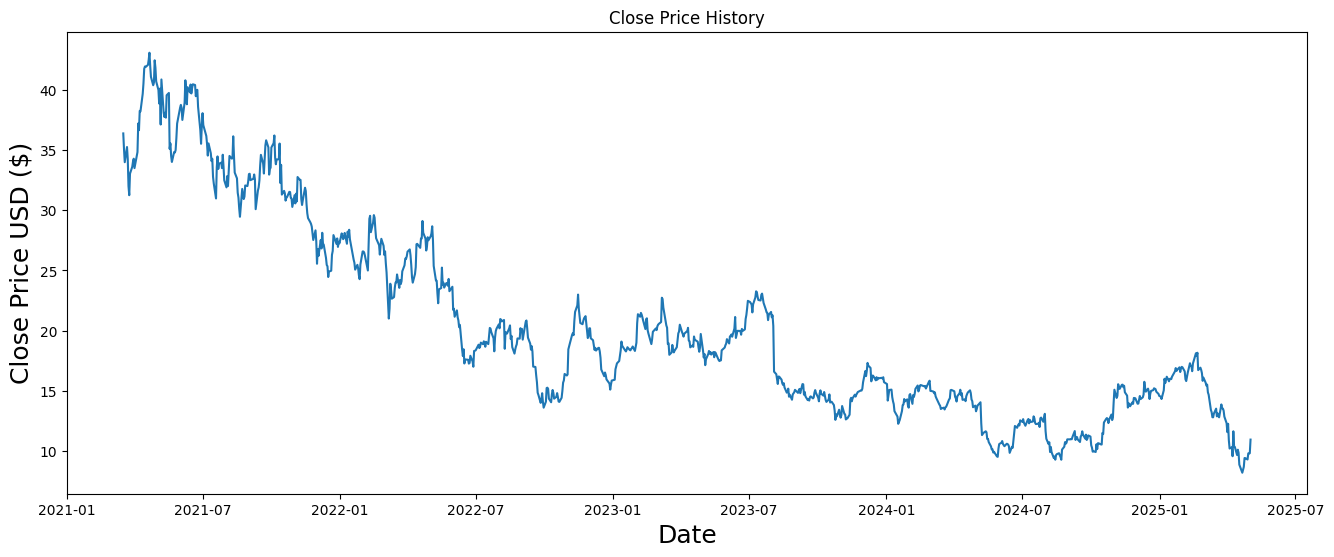

In [9]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()
# plt.savefig("close_price.png")  

In [10]:
df.columns

MultiIndex([( 'Close', 'SNCY'),
            (  'High', 'SNCY'),
            (   'Low', 'SNCY'),
            (  'Open', 'SNCY'),
            ('Volume', 'SNCY')],
           names=['Price', 'Ticker'])

In [11]:
data = df['Close']['SNCY']
dataset = data.values
dataset = data.values.reshape(-1, 1)

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

In [12]:
data.head()

Date
2021-03-17    36.380001
2021-03-18    35.060001
2021-03-19    33.990002
2021-03-22    35.250000
2021-03-23    34.250000
Name: SNCY, dtype: float64

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))




[array([0.80785775, 0.77000287, 0.73931747, 0.77545164, 0.74677369,
       0.68224831, 0.66073986, 0.7120734 , 0.72841982, 0.74075135,
       0.74763399, 0.72526523, 0.76340695, 0.83151707, 0.8156008 ,
       0.86148547, 0.86033833, 0.9022081 , 0.92687115, 0.96185828,
       0.96730705, 0.96616002, 0.97103521, 0.98308001, 1.        ,
       0.96874104, 0.94264411, 0.92256953, 0.9288786 , 0.98193286,
       0.96415257, 0.93174646, 0.91138515, 0.87897904, 0.91453963,
       0.82907936, 0.93633493, 0.85718374, 0.84685977, 0.85718374,
       0.84542578, 0.89876678, 0.90421566, 0.7711499 , 0.784055  ,
       0.75394318, 0.73989094, 0.76340695, 0.76225981, 0.76828215,
       0.79667336, 0.83137365, 0.86922853, 0.87582444, 0.86865496,
       0.83997701, 0.88098648, 0.93432748, 0.91253218, 0.87725832])]
[0.9179810592687361]

[array([0.80785775, 0.77000287, 0.73931747, 0.77545164, 0.74677369,
       0.68224831, 0.66073986, 0.7120734 , 0.72841982, 0.74075135,
       0.74763399, 0.72526523, 0.763

In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)
# x_train.shape

# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("error:", rmse)


/Users/rachel/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


771/771 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0077
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
error: 0.7974925996119685


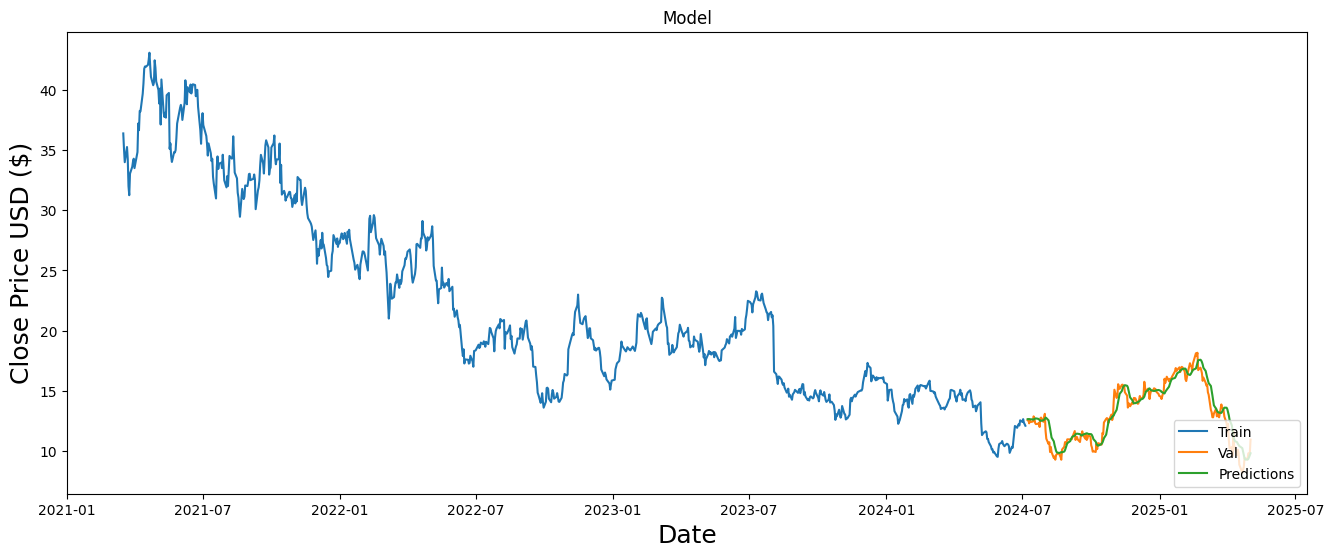

In [15]:
dates = data.index

# Convert dataset (scaled or unscaled) back to a DataFrame
dataset_df = pd.DataFrame(dataset, index=dates, columns=['Close'])

# Split into train and valid DataFrames
train = dataset_df[:training_data_len]
valid = dataset_df[training_data_len:].copy()

# Add predictions to valid set (make sure predictions is same length)
valid['Predictions'] = predictions

# Plot the results
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [16]:
valid

,Close,Predictions
Date,,
2024-07-08,12.58,12.654282
2024-07-09,12.67,12.653189
2024-07-10,12.31,12.667117
2024-07-11,12.60,12.649117
2024-07-12,12.42,12.646451
...,...,...
2025-04-28,9.31,9.304714
2025-04-29,9.82,9.359929
2025-04-30,9.80,9.494657
